<h3>Loading the testing and training data</h3>

In [1]:
import scipy
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_file_path = r'C:\Users\User\Documents\assignment\lab1_train.csv\lab1_train.csv'
train_data = pd.read_csv(train_file_path, delimiter=',')
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


test_file_path = r'C:\Users\User\Documents\assignment\lab1_test.csv\lab1_test.csv'
test_data = pd.read_csv(test_file_path, delimiter=',')
test_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')



C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


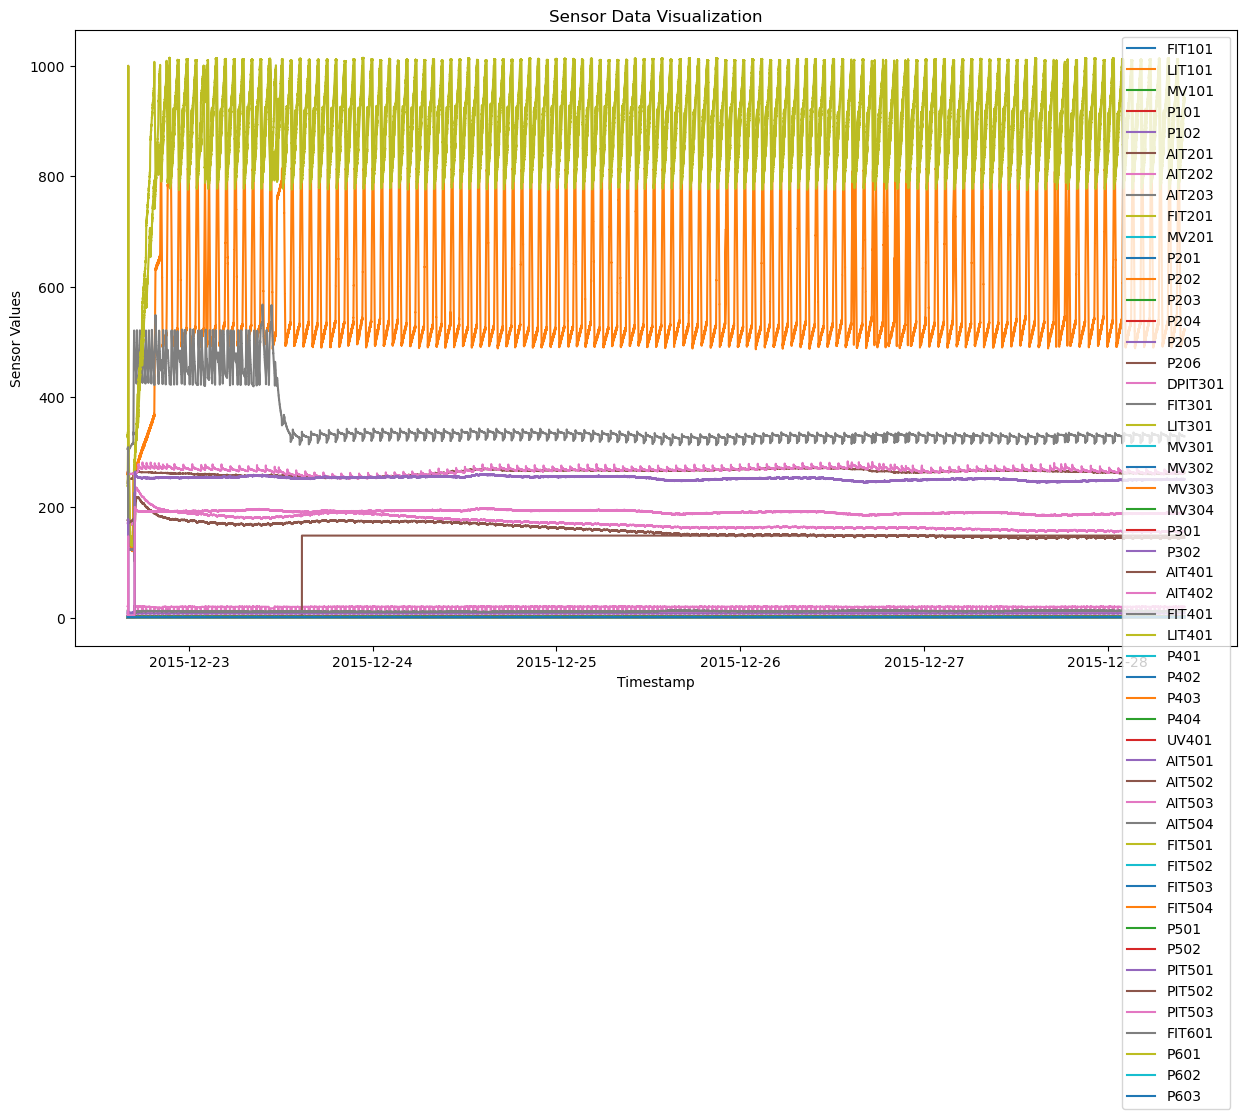

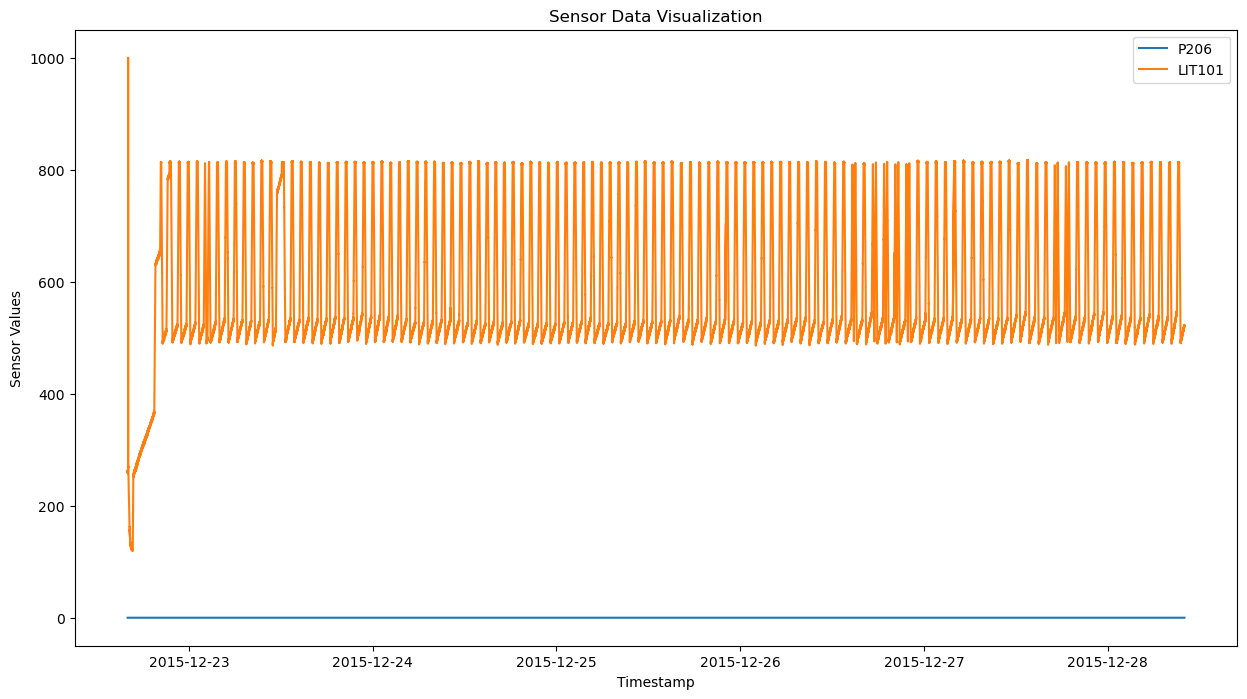

In [2]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data)

visualize_sensor_data(train_data, sensors=['P206', 'LIT101'])

<h4> Types of Signal </h4>

Above we plotted the sensor-values against the timestamp for all the sensors available in the training data.
All signals are analog as they vary with time and continous signals as the data we are dealing with is continuous data.

There are multiple types of signals present in data:
* constant signals that maintain the same sensor value throughout the interval, such as in sensor P206 for a part of the interval
* periodic signals that repeat their behaviour in a given interval, such as in sensor LIT101

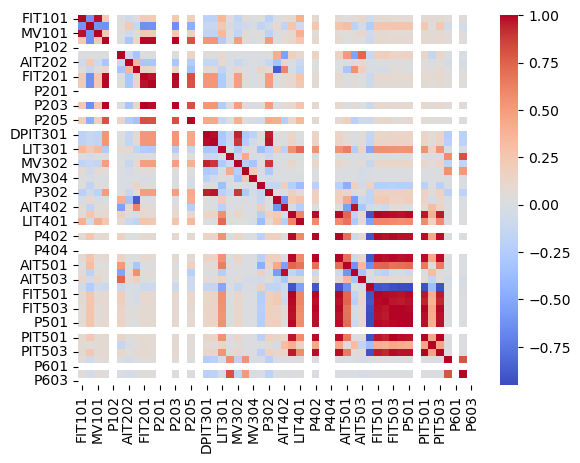

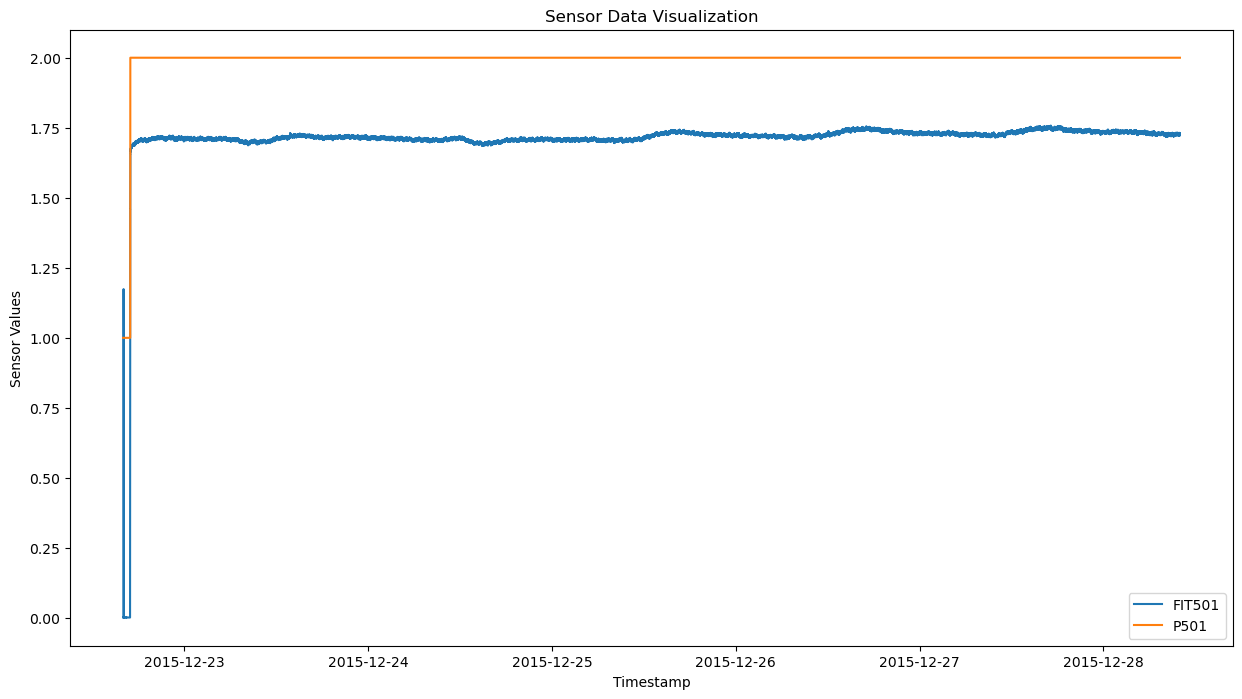

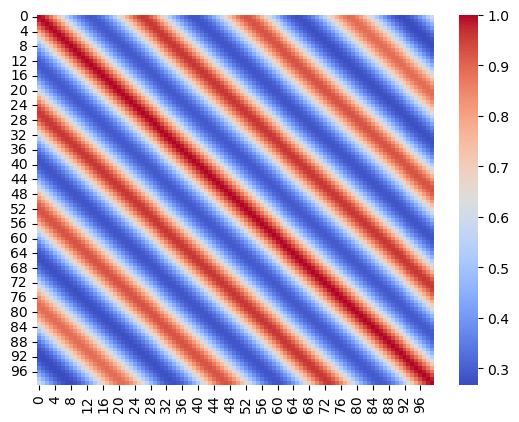

In [3]:
train_df = train_data.drop(columns=['Timestamp', 'Normal/Attack'])
sns.heatmap(train_df.corr(), annot=False, cmap='coolwarm')

visualize_sensor_data(train_data, sensors=['FIT501', 'P501'])
plt.show()


def signal_heatmap(signal= "LIT101", window_shape = 1000, start_index = 1000, end_index = -1):
    # Now we select a column (e.g., LIT101), generate sliding windows of size 20, and compute the correlation matrix between the windows.
    sig = train_df[signal].tolist()
    windows_data = []

    if (end_index == -1): 
        end_index = len(sig)

    windows_data = np.lib.stride_tricks.sliding_window_view(sig[start_index:end_index], window_shape=window_shape)

    windows_df = pd.DataFrame(windows_data)
    windows_correlation_df = windows_df.corr(method="spearman")
    sns.heatmap(windows_correlation_df, annot=False, cmap='coolwarm')
    plt.show()


signal_heatmap(signal="FIT101", window_shape=100, start_index=1000)


<h4>Correlation between data</h4>

From the first plot above, we have plotted a heatmap of the correalations between each of the signals.
- there is a clear red diagonal line which makes sense as these represent the correlation of the sensors with themselves.
- specifically in the bottom right region of the graph, we see that it appear more red. This indicates that the sensors in the bottom right of the graph are more closely correalated with each other, than the other sensors, since a red colour indicates a higher correlation value.
- this claim is confirmed when we plot 2 of the sensors that are present in the bottom right of the graph which is the second plot above, we can see that the 2 sensors are similar in their distribution


The third plot above is a self-correlation graph of a sensor with indicates the correlation of the signal with itself when you shift the data.
- we can see in some regions the shifted data and normal data are highly correalated (red regions) whereas in other regions they are not (blue regions)
- this indicates that the signal of this sensor shows a cyclic behaviour since as you shift the data, the similarity of with the original distribution changes periodically

<h3>Dynamic Time Warping</h3>

We will be using the sensor LIT301

1. First we normalise the training and testing data
2. Now, we plot the training and testing data together to visually see anomalies

C:\Users\User\AppData\Local\Temp\ipykernel_15644\1190642952.py:5: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  sensor_train_data = (s_train - s_train.mean()) / s_train.std()
C:\Users\User\AppData\Local\Temp\ipykernel_15644\1190642952.py:6: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  sensor_test_data = (s_test - s_train.mean()) / s_train.std()


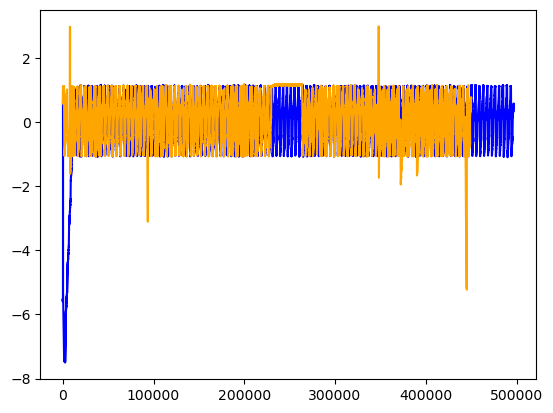

In [4]:
s_train = train_data[['Timestamp', 'LIT301']]
s_test = test_data[['Timestamp', 'LIT301']]

#normalising the training and testing data
sensor_train_data = (s_train - s_train.mean()) / s_train.std()
sensor_test_data = (s_test - s_train.mean()) / s_train.std()


#plotting training and test data to visually see anomalies
plt.plot(np.linspace(0, sensor_train_data['LIT301'].size, sensor_train_data['LIT301'].size), sensor_train_data['LIT301'], color='blue')

plt.plot(np.linspace(0, sensor_test_data['LIT301'].size, sensor_test_data['LIT301'].size), sensor_test_data['LIT301'], color='orange')
plt.show()


<h4>Windows</h4>

First we will need to estimate our window size. Since we want a window that captures the periodicity of the data, we need to choose a window size that is big enough to show that. In this case, we chose a window size of 12500 and have plotted it below. As you can see, we can see periodic signals throughout the window.

As for the step size, we would need to have overlapping between the windows, so the windows are not treated independently therefore we chose a step size of 8000, so there is a little bit of overlapping between the windows.

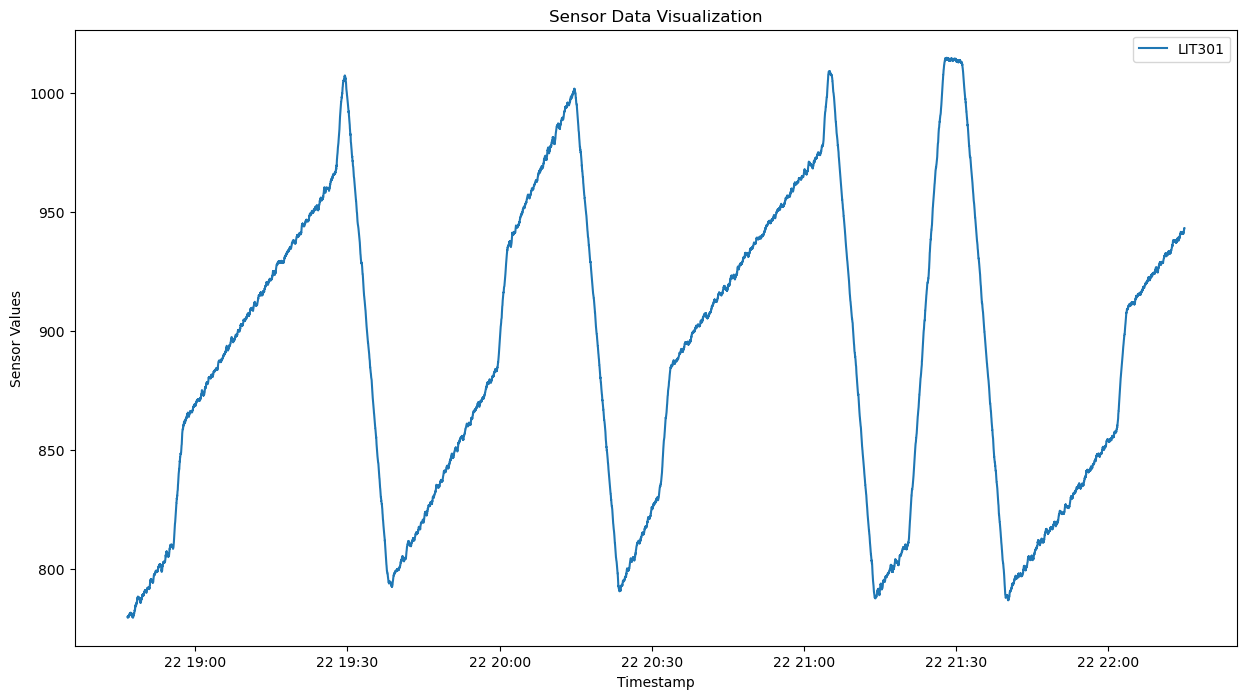

In [5]:
visualize_sensor_data(train_data, window=(10000, 22500), sensors=['LIT301'])


<h4>Implementing Dynamic Time Warping</h4>

Since dynamic time warping is a slow algorithm, we optimise it by subsampling from the data and taking every 50th data point.



In [6]:
def dynamic_time_warping(a, b):
    n = a.size
    m = b.size
    
    dtw_distance = np.inf
    
    # START ANSWER
    distance_matrix = np.full((n, m), np.inf)
    distance_matrix[0, 0] = (a[0] - b[0]) ** 2

    for i in range(n):
        for j in range(m):
            cost = (a[i] - b[j]) ** 2
            
            if(i > 0 and j > 0):
                distance_matrix[i, j] = cost + min(distance_matrix[i-1, j], distance_matrix[i, j-1], distance_matrix[i-1, j-1]) 
            elif (i > 0):
                distance_matrix[i, j] = cost + distance_matrix[i-1, j] 
            elif (j > 0):
                distance_matrix[i, j] = cost + distance_matrix[i, j-1] 

    dtw_distance = np.sqrt(distance_matrix[n - 1, m - 1])
    
    # END ANSWER

    return dtw_distance


window_size = 12500
step_size = 8000

train_lit301 = sensor_train_data['LIT301'].values
test_lit301 = sensor_test_data['LIT301'].values

train_windows = np.lib.stride_tricks.sliding_window_view(train_lit301, window_shape=window_size)[::step_size]
test_window = np.lib.stride_tricks.sliding_window_view(test_lit301, window_shape=window_size)[::step_size]

def sample_window(window, step):
    return window[::step]

closest_windows = []
distances = []


for test in test_window:
    sample_test = sample_window(test, 50)
    dtw_dist = [dynamic_time_warping(sample_test, sample_window(train, 50)) for train in train_windows]
    min_idx = np.argmin(dtw_dist)
    closest_windows.append(min_idx)
    distances.append(dtw_dist[min_idx])



<h4>Dynamic Time Warping Distances</h4>

Now that we have the minimum distances between our test and train windows, we can first plot the distances. As you can see we have some distances that could prove to be anomolous.

Now we should define a threshold to detect our anomalies. Looking from the graph we chose a threshold distance of 7.0 which would ensure we are getting all the high distance anomalies situated above a distance of 17.5 but also anomalies lying around the 7.5 mark as the mean distance lies between 0 and 5.

Now if we filter out the distances that are valid, we are presented with the indices of the training windows that correspond to the closest test windows with anomalies. In this case we detected 8 anomalies. From dynamic time warping, we expect to detect point anomalies, contextual anomalies and collective anomalies since it considers time series and checks segments of data to identify patterns. 

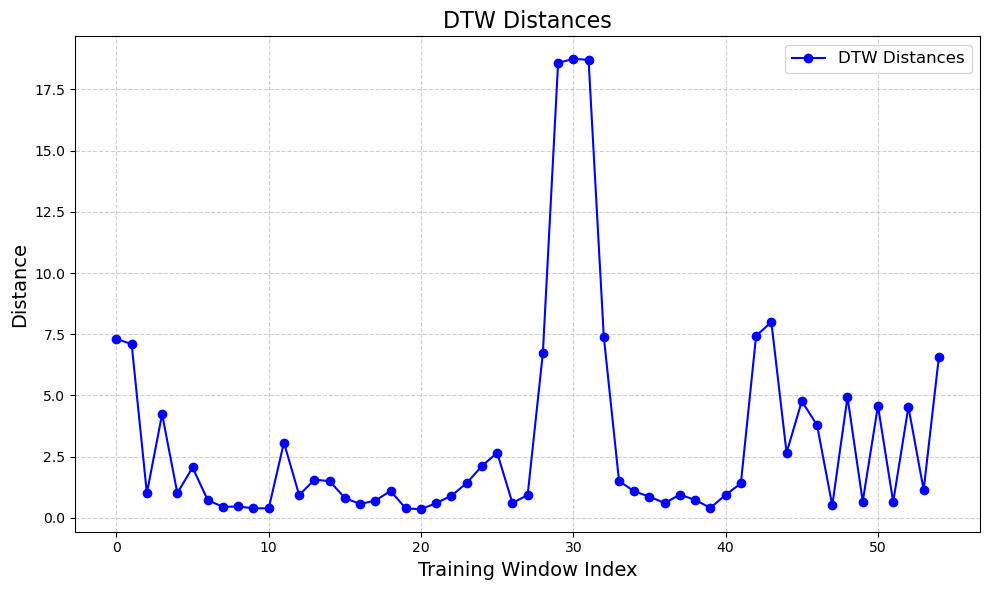

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(distances, marker='o', linestyle='-', color='b', label='DTW Distances')
plt.title("DTW Distances", fontsize=16)
plt.xlabel("Training Window Index", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
dis = np.array(distances)
threshold = 7.0
indexes = []
for i,d in enumerate(dis):
    if(d > threshold):
        indexes.append(i)

print(indexes)


[0, 1, 29, 30, 31, 32, 42, 43]


<h3>Principal Component Analysis</h3>


First, let us define a method that performs PCA on a dataframe. We first obtain the covariance matrix for the data frame and find the eigenvectors and eigenvalues. Now we only want to first k eigenvectors, so we sort the eigenvalues to get the ones that explain the variance the best and return their corresponding eigenvectors.

Then, we define a method that returns a reduced dataframe based on our original dataframe and eigenvectors of our covariance matrix.

In [9]:

def principal_component_analysis(df, k):
    eigenvectors = np.zeros(shape=(df.shape[1], k))

    # START ANSWER
    cov_matrix = np.cov(df, rowvar = False)
    eig_vals, eig_vect = np.linalg.eig(cov_matrix)

    indices = np.argsort(eig_vals)[::-1]
    k_ind = indices[:k]

    eigenvectors = eig_vect[:, k_ind]
    # END ANSWER

    return eigenvectors
    

def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))

    # START ANSWER
    df = df - df.mean()
    projected_data = np.dot(df, eigenvectors)
    # END ANSWER

    return pd.DataFrame(projected_data)


<h4>Reconstructing Data</h4>

Now, we remove the irrelevant columns from our dataframes so we are left with just the data.


Then we perform PCA to get the eigenvectors from the training data and obtain a reduced dataframe of our data using those eigenvectors and dataframe.


Next, we can reconstruct our data by calculating the dot product of our reduced data frame and eigenvectors.


Finally calculate the euclidean distance between the original and reconstructed dataframe and plot those for the training and test data.


We observe large abnormalities in our training data towards the beginning of the session. This is because the sensors needs time to normalise if they are booting up. From the graph of all sensors at beginning of the notebook, we see that all sensors behave this way and this seems like a plausible explanation. We expect PCA to detect point.

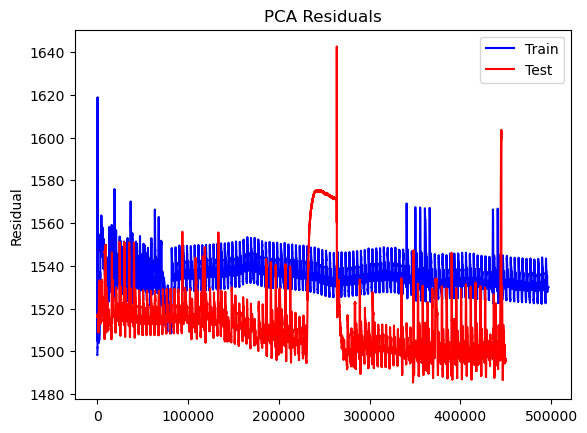

In [10]:
train_df = train_data.drop(columns=['Timestamp', 'Normal/Attack'])
test_df = test_data.drop(columns=['Timestamp', 'Normal/Attack'] )

train_eigenvectors = principal_component_analysis(train_df, 3)

train_reduced = apply_principal_component_analysis(train_df, train_eigenvectors)
test_reduced = apply_principal_component_analysis(test_df, train_eigenvectors)

train_recon = np.dot(train_reduced,train_eigenvectors.T)
test_recon = np.dot(test_reduced,train_eigenvectors.T)

residual_train = np.linalg.norm(train_df - train_recon, axis = 1)
residual_test = np.linalg.norm(test_df - test_recon, axis = 1)


plt.plot(residual_train, label='Training Data Residuals', color='blue')
plt.plot(residual_test, label='Test Data Residuals', color='red')
plt.title('PCA Residuals')
plt.ylabel('Residual')
plt.legend(['Train', 'Test'])
plt.show()


<h4>Choosing the number of components</h4>

Below, we have plotted the average residual distance against the number of components from 1 to 10. We can use the elbow method to determine the number of components that we should use. The rate of decrease skows after k = 3, so we will use 3 components for our principal component analysis.


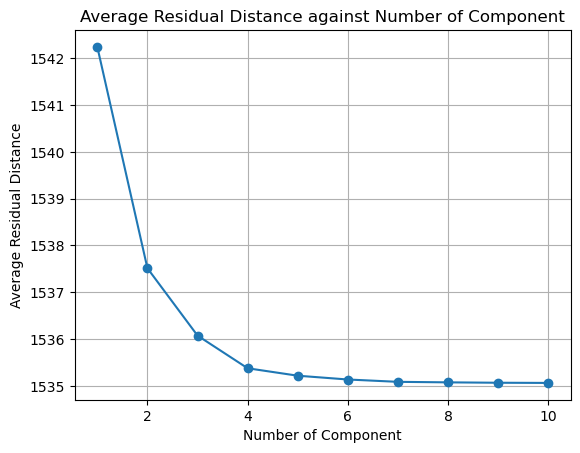

In [11]:
avg = np.zeros(10)

for i in range(1, 11):
    # preparing data
    train_df = train_data.drop(columns=['Timestamp', 'Normal/Attack'])
    test_df = test_data.drop(columns=['Timestamp', 'Normal/Attack'] )

    # computing PCA on the train data
    train_eigenvectors = principal_component_analysis(train_df, i)

    train_reduced = apply_principal_component_analysis(train_df, train_eigenvectors)

    train_recon = np.dot(train_reduced,train_eigenvectors.T)

    residual_train = np.linalg.norm(train_df - train_recon, axis = 1)
    avg[i - 1] = np.mean(residual_train)


plt.plot(np.arange(1, 11), avg, marker = 'o')
plt.title("Average Residual Distance against Number of Component")
plt.xlabel("Number of Component")
plt.ylabel("Average Residual Distance")
plt.grid(True)
